In [1]:
globencs_dir = "/home/modaresi/projects/globenc_analysis/outputs/globencs_v3"
# train_file_name = "[mnli]_[train]_[output_mnli_bert-base-uncased_0001_SEED0042-checkpoint-61360]_[GlobEnc].pkl"
# test_file_name = "[mnli]_[validation_matched]_[output_mnli_bert-base-uncased_0001_SEED0042-checkpoint-61360]_[GlobEnc].pkl"

# train_file_name = "[qnli]_[train]_[output_qnli_bert-base-uncased_0001_SEED0042-checkpoint-16370]_[Decomposition AbsDot Bias].pkl"
# test_file_name = "[qnli]_[validation]_[output_qnli_bert-base-uncased_0001_SEED0042-checkpoint-16370]_[Decomposition AbsDot Bias].pkl"

train_file_name = "[qnli]_[train]_[output_qnli_bert-base-uncased_0001_SEED0042-checkpoint-16370]_[GlobEnc No Bias FFN].pkl"
test_file_name = "[qnli]_[validation]_[output_qnli_bert-base-uncased_0001_SEED0042-checkpoint-16370]_[GlobEnc No Bias FFN].pkl"
max_length = 191
hidden_size = 100
num_labels = 2
num_epochs = 40
CPU_MODE = True
SEP_CENTER = True
REMOVE_SPECIAL_TOKENS = True

In [2]:
# ! nvidia-smi
from keras.datasets import cifar10
import tensorflow as tf

# Hide GPU from visible devices
if CPU_MODE:
    tf.config.set_visible_devices([], 'GPU')

import matplotlib.pyplot as plt
import numpy as np
import logging
from sklearn.metrics import classification_report, confusion_matrix
from time import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

tf.autograph.set_verbosity(0, False)
logging.getLogger("tensorflow").setLevel(logging.ERROR)

if tf.config.experimental.list_logical_devices('GPU'):
    print('GPU found')
else:
    print("No GPU found")

2023-01-09 11:38:44.051263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 11:38:44.158713: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-09 11:38:44.162293: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-09 11:38:44.162305: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

No GPU found


2023-01-09 11:38:46.417816: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
globencs_df_train = pd.read_pickle(f"{globencs_dir}/{train_file_name}")
globencs_df_test = pd.read_pickle(f"{globencs_dir}/{test_file_name}")

In [4]:
def normalize(x):
    return x / x.sum(axis=-1)

In [5]:
x_train_pd = globencs_df_train["importance_last_layer_aggregated"].values
x_train = np.zeros((len(x_train_pd), max_length, max_length), dtype=np.float32)

for idx, val in enumerate(x_train_pd):
    if SEP_CENTER:
        _map = normalize(val)
        sep_idx = globencs_df_train.tokens[idx].index("[SEP]")
        if REMOVE_SPECIAL_TOKENS:
            special_idxes = np.array([i for i,x in enumerate(globencs_df_train.tokens[idx]) if x=="[SEP]" or x=="[CLS]"] + [sep_idx-1])
            _map[:, special_idxes] = 0.0
            _map[special_idxes,:] = 0.0
        shift = 95 - sep_idx
        
        if shift < 0:
            x_train[idx][:len(val)+shift,:len(val)+shift] = _map[-shift:,-shift:]
        else:
            x_train[idx][shift:shift+len(val),shift:shift+len(val)] = _map[:max_length-shift,:max_length-shift]
    else:
        x_train[idx][:len(val),:len(val)] = normalize(val)

# x_train = tf.convert_to_tensor(x_train_np)
# y_train = np.array(globencs_df_train["label"].values, dtype=np.int32)
y_train = np.argmax(np.stack(globencs_df_train["logits"].values), axis=-1)

In [6]:
x_test_pd = globencs_df_test["importance_last_layer_aggregated"].values
x_test = np.zeros((len(x_test_pd), max_length, max_length), dtype=np.float32)

for idx, val in enumerate(x_test_pd):
    _map = normalize(val)
    if SEP_CENTER:
        sep_idx = globencs_df_test.tokens[idx].index("[SEP]")
        if REMOVE_SPECIAL_TOKENS:
            special_idxes = np.array([i for i,x in enumerate(globencs_df_test.tokens[idx]) if x=="[SEP]" or x=="[CLS]"] + [sep_idx-1])
            _map[:, special_idxes] = 0.0
            _map[special_idxes,:] = 0.0
        shift = 95 - sep_idx
        
        if shift < 0:
            x_test[idx][:len(val)+shift,:len(val)+shift] = _map[-shift:,-shift:]
        else:
            x_test[idx][shift:shift+len(val),shift:shift+len(val)] = _map[:max_length-shift,:max_length-shift]
    else:
        x_test[idx][:len(val),:len(val)] = normalize(val)

# x_test = tf.convert_to_tensor(x_test_np)
y_test = np.argmax(np.stack(globencs_df_test["logits"].values), axis=-1)

In [7]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2]))

In [14]:
# with tf.device('/cpu:0'):
#     y_train_np = globencs_df_train["label"].values
#     y_train_temp = np.zeros(shape=(len(y_train_np), 3))
#     for idx, val in enumerate(y_train_np):
#         y_train_temp[idx][val] = 1
        
#     y_test_np = globencs_df_test["label"].values
#     y_test_temp = np.zeros(shape=(len(y_test_np), 3))
#     for idx, val in enumerate(y_test_np):
#         y_test_temp[idx][val] = 1
        
# y_train = tf.convert_to_tensor(list(y_train_temp))
# y_test = tf.convert_to_tensor(list(y_test_temp))

In [8]:
class Trainer:
    def __init__(self, units=1024, activation_function="relu", 
                 optimizer="adam", n_layers=1, loss_function='sparse_categorical_crossentropy', input_size=1024) -> None:
        self.optimizer = optimizer
        self.units = units
        self.activation_function = activation_function
        self.n_layers = n_layers
        self.loss_function = loss_function
        self.input_size = input_size
        self.model = self.build_mlp_model()
        self.history = None
        self.training_time = None
        
    
    def print_summary(self):
        print("######################")
        print(f"Training Time: {self.training_time:.2f}s")
        print("batch size:", self.batch_size)
        print("n_layers:", self.n_layers)
        print("optimizer:", self.optimizer)
        print("activation_function:", self.activation_function)
        print("loss_function", self.loss_function)
        print(self.model.summary())

    def build_mlp_model(self):
        model = tf.keras.Sequential([tf.keras.layers.Input(shape=(self.input_size, ))])
#         for n in range(self.n_layers):
#             model.add(tf.keras.layers.Dense(self.units / 2**n, activation=self.activation_function))
#             model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.Dense(3, activation='softmax'))
        
        model.compile(
            optimizer=self.optimizer,
            loss=self.loss_function,
            metrics=['accuracy']
        )
        return model
    
    def train(self, x_train, y_train, batch_size=32, epochs=50):
        self.batch_size = batch_size
        assert x_train.shape[1:] == (self.input_size, )
#         assert y_train.shape[1:] == (3, )
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            verbose=1,
            patience=5,
            mode='min',
            restore_best_weights=True
        )
        start = time()
        self.history = self.model.fit(
            x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_split=0.1,
            callbacks=[early_stopping],
        )
        self.training_time = time() - start
    
    def plot_history(self):
        fig = plt.figure(figsize=(12, 4))
        metrics = ['loss', 'accuracy']
        for n, metric in enumerate(metrics):
            plt.subplot(1, 2, n+1)
            plt.plot(self.history.epoch, self.history.history[metric], label='Train')
            plt.plot(self.history.epoch, self.history.history[f"val_{metric}"], linestyle="--", label='Validation')
            plt.xlabel('Epoch')
            plt.ylabel(metric)
            plt.title(metric)
        plt.legend()
        plt.show()

    
    def evaluate(self, x_test, y_test):
        assert x_test.shape[1:] == (self.input_size, )
#         assert y_test.shape[1:] == (10, )
        [test_loss,test_acc] = self.model.evaluate(x_test,y_test)
        print("Test Loss:", test_loss, "Test Accuracy:", test_acc)
        test_preds = np.argmax(self.model.predict(x_test), axis=-1)
        # y_test = np.argmax(y_test, axis=-1)
        print(classification_report(y_test, test_preds))
        self.plot_cm(y_test, test_preds)
    
    def plot_cm(self, y_true, preds):
        cm = confusion_matrix(y_true, preds)
        plt.figure(figsize=(7, 5))
        ax = sns.heatmap(cm, annot=True, fmt="d")
        bottom, top = ax.get_ylim()
        ax.set_ylim(bottom + 0.5, top - 0.5)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

In [9]:
trainer = Trainer(
    input_size=max_length*max_length,
    optimizer=tf.optimizers.Adam(learning_rate=0.005)
)

In [10]:
# with tf.device('/cpu:0'):
trainer.train(
    x_train,
    y_train,
    batch_size=64,
    epochs=20
)

Epoch 1/20
1473/1473 [==============================] - 6s 4ms/step - loss: 0.4521 - accuracy: 0.8084 - val_loss: 0.3756 - val_accuracy: 0.8585
Epoch 2/20
1473/1473 [==============================] - 7s 5ms/step - loss: 0.3615 - accuracy: 0.8604 - val_loss: 0.3488 - val_accuracy: 0.8631
Epoch 3/20
1473/1473 [==============================] - 5s 3ms/step - loss: 0.3409 - accuracy: 0.8677 - val_loss: 0.3354 - val_accuracy: 0.8715
Epoch 4/20
1473/1473 [==============================] - 5s 3ms/step - loss: 0.3316 - accuracy: 0.8710 - val_loss: 0.3279 - val_accuracy: 0.8737
Epoch 5/20
1473/1473 [==============================] - 5s 3ms/step - loss: 0.3260 - accuracy: 0.8732 - val_loss: 0.3271 - val_accuracy: 0.8739
Epoch 6/20
1473/1473 [==============================] - 4s 3ms/step - loss: 0.3215 - accuracy: 0.8759 - val_loss: 0.3433 - val_accuracy: 0.8572
Epoch 7/20
1473/1473 [==============================] - 4s 3ms/step - loss: 0.3182 - accuracy: 0.8778 - val_loss: 0.3245 - val_accuracy:

In [11]:
trainer.print_summary()

######################
Training Time: 105.96s
batch size: 64
n_layers: 1
optimizer: <keras.optimizers.optimizer_experimental.adam.Adam object at 0x7faf0c287b10>
activation_function: relu
loss_function sparse_categorical_crossentropy
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 109446    
                                                                 
Total params: 109,446
Trainable params: 109,446
Non-trainable params: 0
_________________________________________________________________
None


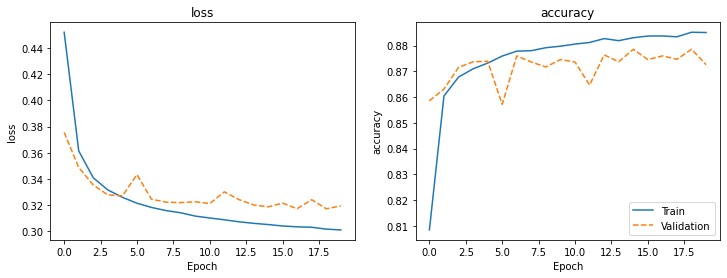

In [12]:
trainer.plot_history()

171/171 [==============================] - 0s 2ms/step - loss: 0.3637 - accuracy: 0.8424
Test Loss: 0.36368173360824585 Test Accuracy: 0.8423942923545837
171/171 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      2687
           1       0.89      0.79      0.84      2776

    accuracy                           0.84      5463
   macro avg       0.85      0.84      0.84      5463
weighted avg       0.85      0.84      0.84      5463



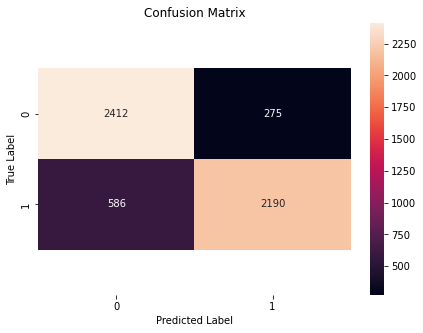

In [13]:
# with tf.device('/cpu:0'):
trainer.evaluate(x_test, y_test)

307/307 [==============================] - 1s 3ms/step - loss: 0.9211 - accuracy: 0.6041
Test Loss: 0.92112797498703 Test Accuracy: 0.6040753722190857
307/307 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.59      0.64      0.62      3479
           1       0.55      0.67      0.60      3123
           2       0.72      0.50      0.59      3213

    accuracy                           0.60      9815
   macro avg       0.62      0.60      0.60      9815
weighted avg       0.62      0.60      0.60      9815



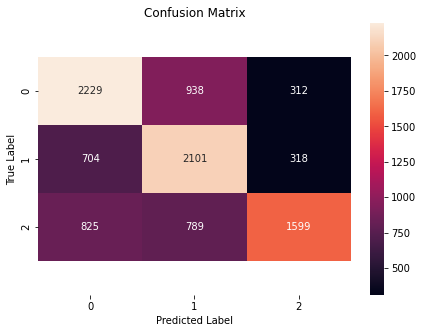

In [24]:
# with tf.device('/cpu:0'):
trainer.evaluate(x_test, y_test)

<AxesSubplot:>

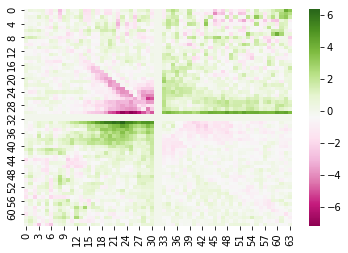

In [15]:
sns.heatmap(np.reshape(trainer.model.layers[0].weights[0][:, 0], (max_length,max_length))[95-32:95+32, 95-32:95+32], cmap="PiYG")

<AxesSubplot:>

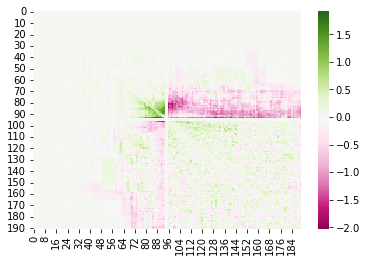

In [24]:
sns.heatmap(np.reshape(trainer.model.layers[0].weights[0][:, 1], (max_length,max_length))[95-32:95+32, 95-32:95+32], cmap="PiYG")

307/307 [==============================] - 1s 2ms/step - loss: 0.9214 - accuracy: 0.5990
Test Loss: 0.9214446544647217 Test Accuracy: 0.5989811420440674
307/307 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.60      0.60      0.60      3479
           1       0.54      0.65      0.59      3123
           2       0.68      0.54      0.60      3213

    accuracy                           0.60      9815
   macro avg       0.61      0.60      0.60      9815
weighted avg       0.61      0.60      0.60      9815



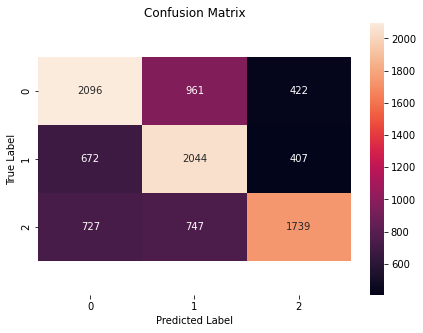

In [22]:
# with tf.device('/cpu:0'):
trainer.evaluate(x_test, y_test)